# Transmission coefficient and derivatives

Import packages and define constants

In [1]:
"""Calling format:
python sympint.py <M*mu>
"""

import sys
import numpy as np
import time
import matplotlib.pyplot as plt

# in these routines, rsub = r-2M (to avoid underflow)

mu = 4.1796514508e-23
alpha = 0.0072973525643

Define step matrix function. Explanation needed here.

In [2]:
# the matrix to step (F,G) from rsub_prev to rsub_next
def stepmatr(M, h, aZ, bY, k, rsub_prev, rsub_next):
    rsub = (rsub_next+rsub_prev)/2.
    dr = rsub_next-rsub_prev
    r = rsub+2*M
    nu = np.sqrt(rsub/r) # sqrt{1-2M/r}

    dmat = np.array([[-k/r, -(h+aZ/r+bY/(r**2))/nu+mu],
        [(h+aZ/r+bY/(r**2))/nu+mu, k/r]])/nu
    
    mat2=dr/2.*dmat
    
    det=mat2[0][0]*mat2[1][1]-mat2[0][1]*mat2[1][0]

    #return( (np.identity(2)+dr/2.*dmat)@np.linalg.inv(np.identity(2)-dr/2.*dmat) ) We calculate the actual matrix:
    return (1/(1-mat2[0][0]-mat2[1][1]+det)*np.array([[1+mat2[0][0]-mat2[1][1]-det,
                                                      2*mat2[0][1]],[2*mat2[1][0],1-mat2[0][0]+mat2[1][1]-det]]))

Define function that calculates transmission coefficient using step matrix. Explanation needed here.

In [3]:
def get_T(M, h, aZ, bY, k):
    '''
    Calculates transmission coefficient. Assumes mu, alpha and stepmatr() defined.
    
    M: mass of black hole in Planck units
    h: particle energy in units of the Hawking temperature
    aZ: Z times alpha. Z is an integer
    bY: Y times 2M alpha. Y is an integer
    k: Schrodinger separation constant. k!=0 and k is an integer
    
    Returns transmission coefficient for given inputs.
    '''

    r_i = 1000000*M
    nstep = 1810000
    drr = -26.6/nstep
    tMat = np.identity(2)
    for i in range(nstep):
        tMat = stepmatr(M,h,aZ,bY,k,r_i,r_i*(1+drr))@tMat
        if np.abs(tMat[0][0]*tMat[1][1])>10**12:
            return 0
        r_i *= 1+drr

    try:
        FGp = np.linalg.solve(tMat, np.array([1j,1]))/2
    except: 
        print("M = ", M)
        print("h = ", h)
        print("aZ = ", aZ)
        print("bY = ", bY)
        print("k = ", k)
        print("tMat = ", tMat)
        exit()
    a = ((h+mu)/(h-mu))**.25
    Fs = FGp[0]*a
    Gs = FGp[1]/a
    Pout = np.abs(Fs-1j*Gs)**2
    Pin = np.abs(Fs+1j*Gs)**2
    return(1-Pout/Pin)

Define the range over which the transmission coefficients have to be calculated.

Required: list of Z values (len(5), centered on 0, integers), list of Y values (len(5), centered on 0, integers), list of BH masses, list of k values (k!=0, integers), and lists of energies for each M.

In [4]:
dz = 1 # must be an integer
dy = 1 # must be an integer

zlist = np.array((-2*dz,-dz,0,dz,2*dz)) # must only contain 5 values
ylist = np.array((-2*dy,-dy,0,dy,2*dy)) # must only contain 5 values

kmax = 5 # must be an integer
klist = np.arange(-kmax,kmax+1,1)
klist = klist[klist!=0]

m1=1e21
m2=2e21
m4=4e21
m8=8e21
mlist=[m1,m2,m4,m8]

th1=1/(8*np.pi*m1)
th2=1/(8*np.pi*m2)
th4=1/(8*np.pi*m4)
th8=1/(8*np.pi*m8)

dh1=0.1*th1
dh2=0.1*th2
dh4=0.1*th4
dh8=0.1*th8

dh1f=0.01*th1
dh2f=0.01*th2
dh4f=0.01*th4
dh8f=0.01*th8

zr1=0.01*th1
zr2=0.01*th2
zr4=0.01*th4
zr8=0.01*th8

zr1f=0.01*th1+10*0.1*th1
zr2f=0.01*th2+20*0.1*th2
zr4f=0.01*th4+41*0.1*th4
zr8f=0.01*th8+83*0.1*th8

hnum=200

hlist1=np.zeros(hnum)
hlist2=np.zeros(hnum)
hlist4=np.zeros(hnum)
hlist8=np.zeros(hnum)

hlist1f=np.zeros(hnum)
hlist2f=np.zeros(hnum)
hlist4f=np.zeros(hnum)
hlist8f=np.zeros(hnum)

for i in range(hnum):
    hlist1[i]=i*dh1+zr1
    hlist2[i]=i*dh2+zr2
    hlist4[i]=i*dh4+zr4
    hlist8[i]=i*dh8+zr8
harray=[hlist1,hlist2,hlist4,hlist8]

for i in range(hnum):
    hlist1f[i]=i*dh1f+zr1f
    hlist2f[i]=i*dh2f+zr2f
    hlist4f[i]=i*dh4f+zr4f
    hlist8f[i]=i*dh8f+zr8f
hfarray=[hlist1f,hlist2f,hlist4f,hlist8f]
    
z21=3.439**2
z22=3.405**2
z24=2.963**2
z28=2.575**2
z2list=[z21,z22,z24,z28]

Define the function that produces an array of transmission coefficients dependent on the range given above. 

It uses nested for loops over ks and energies for Z!=0, Y=0 and Y!=0, Z=0 and calls get_T() in each loop to find the transmission coefficient at each value. It cuts values where h < mu since electrons/positrons cannot be produced at those energies. 

Transmission coefficients are not calculated for ((Z!=0) and (Y!=0)). So all non-zero Z value transmission coefficients have Y=0 and all non-zero Y value transmission coefficients have Z=0.

The transmission coefficient array which is returned can be used as follows:

outputArray[energy list index, 0 for Y=0 values or 1 for Z=0 values, Z list index (if prev value 0) or Y list index (if prev value 1), k list index]

In [5]:
def make_T(mass, hList, zList, yList, kList):
    '''
    Makes an array of the transmission coefficients given lists of parameters. Assumes alpha and mu defined.
    
    mass: black hole mass in Planck units
    hList: list of electron/positron energies. Should be dependent on black hole mass
    zList is the list of Z values. zList is ordered, has 5 equally spaced, integer points and is centered on 0. 
    yList is the list of Y values. yList is ordered, has 5 equally spaced, integer points and is centered on 0.
    klist is the list of Schrodinger separation constants. kList is equally spaced, integer points centered on 0, 
    but does not include 0.
    
    Returns the transmission coefficient array.
    '''
    start_time = time.time()
    counter = 0
    z_or_y = np.array((0,1))
    tArray = np.zeros((len(hList),2,5,len(kList)))
    m=mass
    for hi in range(len(hList)):
        h=hList[hi]
        if h>mu:
            for ki in range(len(kList)):
                k=kList[ki]
                for x in z_or_y:
                    if x==0:
                        bY=0
                        for i in range(5):
                            z=zList[i]
                            aZ=alpha*z
                            tArray[hi,x,i,ki]=get_T(m,h,aZ,bY,k)
                            counter+=1
                            if counter==1:
                                print("Runtime after first successful loop:", time.time() - start_time)
                                sys.stdout.flush()
                    else:
                        aZ=0
                        for i in range(5):
                            y=yList[i]
                            bY=2*alpha*m*y
                            tArray[hi,x,i,ki]=get_T(m,h,aZ,bY,k)
                            counter+=1
                            if counter==1:
                                print("Runtime after first successful loop:", time.time() - start_time)
                                sys.stdout.flush()
        print("hi = ", hi, ", h = ",h,", Runtime = ", time.time()-start_time)
        sys.stdout.flush() 
    return tArray

Now define functions that calculate derivatives of transmission coefficients with respect to Z and Y (evaluated at Z, Y=0) using the output array of transmission coefficients calculated with make_T. 

First derivatives can be calculated as both 3-point (lowest order) or 5-point (second lowest order) numerical derivatives. 5-point derivatives are assumed if none is specified.

Second derivative is calculated with 5-point numerical derivative (lowest order).

In [6]:
def make_dTdZ(tArray, dZ,n=5):
    '''
    Uses array of transmission coefficients to create an array of Z derivatives of the transmission coefficient. 
    Can do 3pt or 5pt numerical derivative.
    
    tArray is the array of transmission coefficients and has dim(m,h,z,y,k)
    dZ is the spacing between Z values
    n is either 3 or 5, depending on whether the 3pt or 5pt numerical derivative is used.
    
    Returns array of Z derivatives of the transmission coefficient.
    '''
    if n==5:
        dTdZ=1/(12*dZ)*(tArray[:,0,0,:]-8*tArray[:,0,1,:]
                    +8*tArray[:,0,3,:]-tArray[:,0,4,:])
    elif n==3:
        dTdZ=1/(2*dZ)*(tArray[:,0,3,:]-tArray[:,0,1,:])
    else:
        print("Wrong n, rerun function with n=3 or n=5. Passing no n value defaults to n=5.")
        dTdZ=0
    return dTdZ

In [7]:
def make_dTdY(tArray, dY,n=5):
    '''
    Uses array of transmission coefficients to create an array of Y derivatives of the transmission coefficient. 
    Can do 3pt or 5pt numerical derivative.
    
    tArray is the array of transmission coefficients and has dim(m,h,z,y,k)
    dY is the spacing between Y values
    n is either 3 or 5, depending on whether the 3pt or 5pt numerical derivative is used.
    
    Returns array of Y derivatives of the transmission coefficient.
    '''
    if n==5:
        dTdY=1/(12*dY)*(tArray[:,1,0,:]-8*tArray[:,1,1,:]
                    +8*tArray[:,1,3,:]-tArray[:,1,4,:])
    elif n==3:
        dTdY=1/(2*dY)*(tArray[:,1,3,:]-tArray[:,1,1,:])
    else:
        print("Wrong n, rerun function with n=3 or n=5. Passing no n value defaults to n=5.")
        dTdY=0
    return dTdY

In [8]:
def make_d2TdZ2(tArray, dZ):
    '''
    Uses array of transmission coefficients to create an array of second Z derivatives of the transmission coefficient. 
    
    tArray is the array of transmission coefficients and has dim(m,h,z,y,k)
    dZ is the spacing between Z values
    
    Returns array of second Z derivatives of the transmission coefficient.
    '''
    d2TdZ2=1/(12*(dZ**2))*(-tArray[:,0,0,:]+16*tArray[:,0,1,:]-30*tArray[:,0,2,:]
                           +16*tArray[:,0,3,:]-tArray[:,0,4,:])
    return d2TdZ2

Create an array of transmission coefficients using make_T. This is normally done on the supercomputer.

In [9]:
'''
testT=make_T(mlist, harray, zlist, ylist, klist)
np.savez("Transmission_Data_1",T=T)
'''

'\ntestT=make_T(mlist, harray, zlist, ylist, klist)\nnp.savez("Transmission_Data_1",T=T)\n'

Load the file you created with all the transmission coefficients and derivatives

In [10]:
'''
dataA=np.load("TransmissionData/Old/Transmission_Data_1e21_ob_2_h1.npz")
dataB=np.load("TransmissionData/Old/Transmission_Data_1e21_ob_2_h2.npz")
TA=dataA["T"]
TB=dataB["T"]
Tconcat=np.concatenate((TA,TB),axis=0)
np.savez("TransmissionData/Transmission_Data_1e21_ob_2.npz",T=Tconcat)

dataA=np.load("TransmissionData/Old/Transmission_Data_2e21_ob_2_h1.npz")
dataB=np.load("TransmissionData/Old/Transmission_Data_2e21_ob_2_h2.npz")
TA=dataA["T"]
TB=dataB["T"]
Tconcat=np.concatenate((TA,TB),axis=0)
np.savez("TransmissionData/Transmission_Data_2e21_ob_2.npz",T=Tconcat)

dataA=np.load("TransmissionData/Old/Transmission_Data_4e21_fine_ob_2_h1.npz")
dataB=np.load("TransmissionData/Old/Transmission_Data_4e21_fine_ob_2_h2.npz")
TA=dataA["T"]
TB=dataB["T"]
Tconcat=np.concatenate((TA,TB),axis=0)
np.savez("TransmissionData/Transmission_Data_4e21_fine_ob_2.npz",T=Tconcat)

dataA=np.load("TransmissionData/Old/Transmission_Data_8e21_fine_ob_2_h1.npz")
dataB=np.load("TransmissionData/Old/Transmission_Data_8e21_fine_ob_2_h2.npz")
TA=dataA["T"]
TB=dataB["T"]
Tconcat=np.concatenate((TA,TB),axis=0)
np.savez("TransmissionData/Transmission_Data_8e21_fine_ob_2.npz",T=Tconcat)
'''

'\ndataA=np.load("TransmissionData/Old/Transmission_Data_1e21_ob_2_h1.npz")\ndataB=np.load("TransmissionData/Old/Transmission_Data_1e21_ob_2_h2.npz")\nTA=dataA["T"]\nTB=dataB["T"]\nTconcat=np.concatenate((TA,TB),axis=0)\nnp.savez("TransmissionData/Transmission_Data_1e21_ob_2.npz",T=Tconcat)\n\ndataA=np.load("TransmissionData/Old/Transmission_Data_2e21_ob_2_h1.npz")\ndataB=np.load("TransmissionData/Old/Transmission_Data_2e21_ob_2_h2.npz")\nTA=dataA["T"]\nTB=dataB["T"]\nTconcat=np.concatenate((TA,TB),axis=0)\nnp.savez("TransmissionData/Transmission_Data_2e21_ob_2.npz",T=Tconcat)\n\ndataA=np.load("TransmissionData/Old/Transmission_Data_4e21_fine_ob_2_h1.npz")\ndataB=np.load("TransmissionData/Old/Transmission_Data_4e21_fine_ob_2_h2.npz")\nTA=dataA["T"]\nTB=dataB["T"]\nTconcat=np.concatenate((TA,TB),axis=0)\nnp.savez("TransmissionData/Transmission_Data_4e21_fine_ob_2.npz",T=Tconcat)\n\ndataA=np.load("TransmissionData/Old/Transmission_Data_8e21_fine_ob_2_h1.npz")\ndataB=np.load("Transmission

In [11]:
data1=np.load("TransmissionData/Transmission_Data_1e21_ob_2.npz")
data2=np.load("TransmissionData/Transmission_Data_2e21_ob_2.npz")
data4=np.load("TransmissionData/Transmission_Data_4e21_ob_2.npz")
data8=np.load("TransmissionData/Transmission_Data_8e21_ob_2.npz")

data1f=np.load("TransmissionData/Transmission_Data_1e21_fine_ob_2.npz")
data2f=np.load("TransmissionData/Transmission_Data_2e21_fine_ob_2.npz")
data4f=np.load("TransmissionData/Transmission_Data_4e21_fine_ob_2.npz")
data8f=np.load("TransmissionData/Transmission_Data_8e21_fine_ob_2.npz")

'''
data1old=np.load("TransmissionData/Old/Transmission_Data_1e21_ob.npz")
data2old=np.load("TransmissionData/Old/Transmission_Data_2e21_ob.npz")
data4old=np.load("TransmissionData/Old/Transmission_Data_4e21_ob.npz")
data8old=np.load("TransmissionData/Old/Transmission_Data_8e21_ob.npz")
'''

Rename the arrays from the files

In [12]:
T1=data1["T"]
dTdZ1=make_dTdZ(T1,dz)
dTdY1=make_dTdY(T1,dy)
d2TdZ21=make_d2TdZ2(T1,dz)

T2=data2["T"]
dTdZ2=make_dTdZ(T2,dz)
dTdY2=make_dTdY(T2,dy)
d2TdZ22=make_d2TdZ2(T2,dz)

T4=data4["T"]
dTdZ4=make_dTdZ(T4,dz)
dTdY4=make_dTdY(T4,dy)
d2TdZ24=make_d2TdZ2(T4,dz)

T8=data8["T"]
dTdZ8=make_dTdZ(T8,dz)
dTdY8=make_dTdY(T8,dy)
d2TdZ28=make_d2TdZ2(T8,dz)


T1f=data1f["T"]
dTdZ1f=make_dTdZ(T1f,dz)
dTdY1f=make_dTdY(T1f,dy)
d2TdZ21f=make_d2TdZ2(T1f,dz)

T2f=data2f["T"]
dTdZ2f=make_dTdZ(T2f,dz)
dTdY2f=make_dTdY(T2f,dy)
d2TdZ22f=make_d2TdZ2(T2f,dz)

T4f=data4f["T"]
dTdZ4f=make_dTdZ(T4f,dz)
dTdY4f=make_dTdY(T4f,dy)
d2TdZ24f=make_d2TdZ2(T4f,dz)


T8f=data8f["T"]
dTdZ8f=make_dTdZ(T8f,dz)
dTdY8f=make_dTdY(T8f,dy)
d2TdZ28f=make_d2TdZ2(T8f,dz)

'''
T1old=data1old["T"]
dTdZ1old=make_dTdZ(T1old,dz)
dTdY1old=make_dTdY(T1old,dy)
d2TdZ21old=make_d2TdZ2(T1old,dz)

T2old=data2old["T"]
dTdZ2old=make_dTdZ(T2old,dz)
dTdY2old=make_dTdY(T2old,dy)
d2TdZ22old=make_d2TdZ2(T2old,dz)

T4old=data4old["T"]
dTdZ4old=make_dTdZ(T4old,dz)
dTdY4old=make_dTdY(T4old,dy)
d2TdZ24old=make_d2TdZ2(T4old,dz)

T8old=data8old["T"]
dTdZ8old=make_dTdZ(T8old,dz)
dTdY8old=make_dTdY(T8old,dy)
d2TdZ28old=make_d2TdZ2(T8old,dz)
'''

Tarray=[T1,T2,T4,T8]
dTdZarray=[dTdZ1,dTdZ2,dTdZ4,dTdZ8]
dTdYarray=[dTdY1,dTdY2,dTdY4,dTdY8]
d2TdZ2array=[d2TdZ21,d2TdZ22,d2TdZ24,d2TdZ28]


Tfarray=[T1f,T2f,T4f,T8f]
dTdZfarray=[dTdZ1f,dTdZ2f,dTdZ4f,dTdZ8f]
dTdYfarray=[dTdY1f,dTdY2f,dTdY4f,dTdY8f]
d2TdZ2farray=[d2TdZ21f,d2TdZ22f,d2TdZ24f,d2TdZ28f]

'''
Toldarray=[T1old,T2old,T4old,T8old]
dTdZoldarray=[dTdZ1old,dTdZ2old,dTdZ4old,dTdZ8old]
dTdYoldarray=[dTdY1old,dTdY2old,dTdY4old,dTdY8old]
d2TdZ2oldarray=[d2TdZ21old,d2TdZ22old,d2TdZ24old,d2TdZ28old]
'''

Use the transmission coefficient arrays and their derivative arrays to determine the b0 and b1 terms in the spectra

t01 is term 1 of b0, t02 is term 2 of b0, etc. All terms are already summed over k and contain the prefactors needed to be in units of dN/dhdt.

$$t_{01}=\sum_{k}\left(\frac{2j+1}{2 \pi}\right) \frac{dT}{dZ} f_{up}$$

$$t_{02}=-\sum_{k}\left(\frac{2j+1}{2 \pi} \right) \frac{1}{2} \frac{dT}{dY} f_{up}$$

$$t_{03}=\sum_{k}\left(\frac{2j+1}{2 \pi}\right) \frac{\alpha}{4 M} T \frac{df_{up}}{dh}$$

$$t_{04}=-\sum_{k}\left(\frac{2j+1}{2 \pi}\right) \frac{1}{2} T \frac{dT}{dZ} f_{up}^2$$

$$t_{05}=-\sum_{k}\left(\frac{2j+1}{2 \pi}\right) \frac{\alpha}{2 M} T^2 f_{up} \frac{df_{up}}{dh}$$

In [13]:
def make_b0(mass, hList, kList, Tarr, dTdZarr, dTdYarr):
    '''
    This function returns the contribution to the spectrum from the b0 stochastic charge term,
    as well as the term-by-term contribution to b0. Assumes alpha, mu defined.
    
    mass: black hole mass in Planck mass units
    hList: list of energy values in units oh Hawking temperature
    kList: list of Schrodinger separation constants (integers, k!=0)
    Tarr: array of transmission coefficients, which depends on m, h, aZ, bY, k
    dTdZarr: array of derivatives of transmission coefficients with respect to Z, which depends on m, h, k
    dTdYarr: array of derivatives of transmission coefficients with respect to Y, which depends on m, h, k
    
    Outputs a dictionary with keys b0, t01, t02, t03, t04 and t05 which are associated with the relevant arrays, 
    each depending on mass and energy.
    '''
    b0=np.zeros((len(hList)))
    t01=np.zeros((len(hList)))
    t02=np.zeros((len(hList)))
    t03=np.zeros((len(hList)))
    t04=np.zeros((len(hList)))
    t05=np.zeros((len(hList)))
    m=mass
    for hi in range(len(hList)):
        h=hList[hi]
        exp=np.exp(8*np.pi*m*h)
        fup=1/(exp+1)
        #dfup=-8*m*np.pi*exp/((1+exp)**2)
        dfup=-2*m*np.pi/(np.cosh(4*np.pi*m*h)**2)
        b0_sum_val=0
        t1_sum_val=0
        t2_sum_val=0
        t3_sum_val=0
        t4_sum_val=0
        t5_sum_val=0
        for ki in range(len(kList)):
            k=kList[ki]
            j=np.absolute(k)-1/2
            t1=(2*j+1)*dTdZarr[hi,ki]*fup/(2*np.pi)
            t1_sum_val+=t1
            t2=-(2*j+1)*1/2*dTdYarr[hi,ki]*fup/(2*np.pi)
            t2_sum_val+=t2
            t3=(2*j+1)*alpha/(4*m)*Tarr[hi,0,2,ki]*dfup/(2*np.pi)
            t3_sum_val+=t3
            t4=-(2*j+1)*1/2*Tarr[hi,0,2,ki]*dTdZarr[hi,ki]*(fup**2)/(2*np.pi)
            t4_sum_val+=t4
            t5=-(2*j+1)*alpha/(2*m)*(Tarr[hi,0,2,ki]**2)*fup*dfup/(2*np.pi)
            t5_sum_val+=t5
            b0_sum_val+=t1+t2+t3+t4+t5
        b0[hi]=b0_sum_val
        t01[hi]=t1_sum_val
        t02[hi]=t2_sum_val
        t03[hi]=t3_sum_val
        t04[hi]=t4_sum_val
        t05[hi]=t5_sum_val
    d={"b0": b0, "t01": t01, "t02": t02, "t03": t03, "t04": t04, "t05": t05}
    return d

In [14]:
b0dict1=make_b0(m1,hlist1,klist,T1,dTdZ1,dTdY1)
b01=b0dict1["b0"]
t011=b0dict1["t01"]
t021=b0dict1["t02"]
t031=b0dict1["t03"]
t041=b0dict1["t04"]
t051=b0dict1["t05"]

b0dict2=make_b0(m2,hlist2,klist,T2,dTdZ2,dTdY2)
b02=b0dict2["b0"]
t012=b0dict2["t01"]
t022=b0dict2["t02"]
t032=b0dict2["t03"]
t042=b0dict2["t04"]
t052=b0dict2["t05"]

b0dict4=make_b0(m4,hlist4,klist,T4,dTdZ4,dTdY4)
b04=b0dict4["b0"]
t014=b0dict4["t01"]
t024=b0dict4["t02"]
t034=b0dict4["t03"]
t044=b0dict4["t04"]
t054=b0dict4["t05"]

b0dict8=make_b0(m8,hlist8,klist,T8,dTdZ8,dTdY8)
b08=b0dict8["b0"]
t018=b0dict8["t01"]
t028=b0dict8["t02"]
t038=b0dict8["t03"]
t048=b0dict8["t04"]
t058=b0dict8["t05"]

b0dict1f=make_b0(m1,hlist1f,klist,T1f,dTdZ1f,dTdY1f)
b01f=b0dict1f["b0"]
t011f=b0dict1f["t01"]
t021f=b0dict1f["t02"]
t031f=b0dict1f["t03"]
t041f=b0dict1f["t04"]
t051f=b0dict1f["t05"]

b0dict2f=make_b0(m2,hlist2f,klist,T2f,dTdZ2f,dTdY2f)
b02f=b0dict2f["b0"]
t012f=b0dict2f["t01"]
t022f=b0dict2f["t02"]
t032f=b0dict2f["t03"]
t042f=b0dict2f["t04"]
t052f=b0dict2f["t05"]

b0dict4f=make_b0(m4,hlist4f,klist,T4f,dTdZ4f,dTdY4f)
b04f=b0dict4f["b0"]
t014f=b0dict4f["t01"]
t024f=b0dict4f["t02"]
t034f=b0dict4f["t03"]
t044f=b0dict4f["t04"]
t054f=b0dict4f["t05"]

b0dict8f=make_b0(m8,hlist8f,klist,T8f,dTdZ8f,dTdY8f)
b08f=b0dict8f["b0"]
t018f=b0dict8f["t01"]
t028f=b0dict8f["t02"]
t038f=b0dict8f["t03"]
t048f=b0dict8f["t04"]
t058f=b0dict8f["t05"]

b0dict1old=make_b0(m1,hlist1,klist,T1old,dTdZ1old,dTdY1old)
b01old=b0dict1old["b0"]
t011old=b0dict1old["t01"]
t021old=b0dict1old["t02"]
t031old=b0dict1old["t03"]
t041old=b0dict1old["t04"]
t051old=b0dict1old["t05"]

b0dict2old=make_b0(m2,hlist2,klist,T2old,dTdZ2old,dTdY2old)
b02old=b0dict2old["b0"]
t012old=b0dict2old["t01"]
t022old=b0dict2old["t02"]
t032old=b0dict2old["t03"]
t042old=b0dict2old["t04"]
t052old=b0dict2old["t05"]

b0dict4old=make_b0(m4,hlist4,klist,T4old,dTdZ4old,dTdY4old)
b04old=b0dict4old["b0"]
t014old=b0dict4old["t01"]
t024old=b0dict4old["t02"]
t034old=b0dict4old["t03"]
t044old=b0dict4old["t04"]
t054old=b0dict4old["t05"]

b0dict8old=make_b0(m8,hlist8,klist,T8old,dTdZ8old,dTdY8old)
b08old=b0dict8old["b0"]
t018old=b0dict8old["t01"]
t028old=b0dict8old["t02"]
t038old=b0dict8old["t03"]
t048old=b0dict8old["t04"]
t058old=b0dict8old["t05"]

b0array=[b01,b02,b04,b08]
t01array=[t011,t012,t014,t018]
t02array=[t021,t022,t024,t028]
t03array=[t031,t032,t034,t038]
t04array=[t041,t042,t044,t048]
t05array=[t051,t052,t054,t058]

b0farray=[b01f,b02f,b04f,b08f]
t01farray=[t011f,t012f,t014f,t018f]
t02farray=[t021f,t022f,t024f,t028f]
t03farray=[t031f,t032f,t034f,t038f]
t04farray=[t041f,t042f,t044f,t048f]
t05farray=[t051f,t052f,t054f,t058f]

b0oldarray=[b01old,b02old,b04old,b08old]
t01oldarray=[t011old,t012old,t014old,t018old]
t02oldarray=[t021old,t022old,t024old,t028old]
t03oldarray=[t031old,t032old,t034old,t038old]
t04oldarray=[t041old,t042old,t044old,t048old]
t05oldarray=[t051old,t052old,t054old,t058old]

t11 is term 1 of b1, t12 is term 2 of b1, etc. All terms are already summed over k and contain the prefactors and <Z^2> needed to be in units of dN/dhdt.

$$t_{11}=\sum_{k}\left(2j+1\right) \left< Z^2 \right> \frac{\alpha^2}{16 \pi M^2} T \frac{d^2f_{up}}{dh^2}$$

$$t_{12}=\sum_{k}\left(2j+1\right) \left< Z^2 \right> \frac{\alpha}{4 \pi M} \frac{dT}{dZ} \frac{df_{up}}{dh}$$

$$t_{13}=\sum_{k}\left(2j+1\right) \left< Z^2 \right> \frac{1}{4 \pi} \frac{d^2T}{dZ^2} f_{up}$$

In [15]:
def make_b1(mass, hList, kList, z2, Tarr, dTdZarr, d2TdZ2arr):
    '''
    This function returns the contribution to the spectrum from the b1 stochastic charge term,
    as well as the term-by-term contribution to b1. Assumes alpha, mu defined.
    
    mass: black hole mass in Planck mass units
    hList: list of energy values
    kList: list of Schrodinger separation constants (integers, k!=0)
    z2: expectation value of Z^2
    Tarr: array of transmission coefficients, which depends on m, h, aZ, bY, k
    dTdZarr: array of derivatives of transmission coefficients with respect to Z, which depends on m, h, k
    d2TdZ2arr: array of second derivatives of transmission coefficients with respect to Z, which depends on m, h, k
    
    Outputs a dictionary with keys b1, t11, t12 and t13 which are associated with the relevant arrays, 
    each depending on mass and energy.
    '''
    b1=np.zeros((len(hList)))
    t11=np.zeros((len(hList)))
    t12=np.zeros((len(hList)))
    t13=np.zeros((len(hList)))
    m=mass
    for hi in range(len(hList)):
        h=hList[hi]
        exp=np.exp(8*np.pi*m*h)
        fup=1/(exp+1)
        #dfup=-8*m*np.pi*exp/((1+exp)**2)
        cosh=np.cosh(4*np.pi*m*h)**2
        dfup=-2*m*np.pi/cosh
        #ddfup=64*(m**2)*(np.pi**2)*(2*(exp**2)/((1+exp)**3)-exp/((1+exp)**2))
        ddfup=16*(m**2)*(np.pi**2)*np.tanh(4*np.pi*m*h)/cosh
        b1_sum_val=0
        t1_sum_val=0
        t2_sum_val=0
        t3_sum_val=0
        for ki in range(len(kList)):
            k=kList[ki]
            j=np.absolute(k)-1/2
            t1=(2*j+1)*z2/(4*np.pi)*(alpha**2)/(4*(m**2))*Tarr[hi,0,0,ki]*ddfup
            t1_sum_val+=t1
            t2=(2*j+1)*z2/(4*np.pi)*alpha/m*dTdZarr[hi,ki]*dfup
            t2_sum_val+=t2
            t3=(2*j+1)*z2/(4*np.pi)*d2TdZ2arr[hi,ki]*fup
            t3_sum_val+=t3
            b1_sum_val+=t1+t2+t3
        b1[hi]=b1_sum_val
        t11[hi]=t1_sum_val
        t12[hi]=t2_sum_val
        t13[hi]=t3_sum_val
    d={"b1": b1, "t11": t11, "t12": t12, "t13": t13}
    return d

In [16]:
b1dict1=make_b1(m1,hlist1,klist,z21,T1,dTdZ1,d2TdZ21)
b11=b1dict1["b1"]
t111=b1dict1["t11"]
t121=b1dict1["t12"]
t131=b1dict1["t13"]

b1dict2=make_b1(m2,hlist2,klist,z22,T2,dTdZ2,d2TdZ22)
b12=b1dict2["b1"]
t112=b1dict2["t11"]
t122=b1dict2["t12"]
t132=b1dict2["t13"]

b1dict4=make_b1(m4,hlist4,klist,z24,T4,dTdZ4,d2TdZ24)
b14=b1dict4["b1"]
t114=b1dict4["t11"]
t124=b1dict4["t12"]
t134=b1dict4["t13"]

b1dict8=make_b1(m8,hlist8,klist,z28,T8,dTdZ8,d2TdZ28)
b18=b1dict8["b1"]
t118=b1dict8["t11"]
t128=b1dict8["t12"]
t138=b1dict8["t13"]

b1dict1f=make_b1(m1,hlist1f,klist,z21,T1f,dTdZ1f,d2TdZ21f)
b11f=b1dict1f["b1"]
t111f=b1dict1f["t11"]
t121f=b1dict1f["t12"]
t131f=b1dict1f["t13"]

b1dict2f=make_b1(m2,hlist2f,klist,z22,T2f,dTdZ2f,d2TdZ22f)
b12f=b1dict2f["b1"]
t112f=b1dict2f["t11"]
t122f=b1dict2f["t12"]
t132f=b1dict2f["t13"]

b1dict4f=make_b1(m4,hlist4f,klist,z24,T4f,dTdZ4f,d2TdZ24f)
b14f=b1dict4f["b1"]
t114f=b1dict4f["t11"]
t124f=b1dict4f["t12"]
t134f=b1dict4f["t13"]

b1dict8f=make_b1(m8,hlist8f,klist,z28,T8f,dTdZ8f,d2TdZ28f)
b18f=b1dict8f["b1"]
t118f=b1dict8f["t11"]
t128f=b1dict8f["t12"]
t138f=b1dict8f["t13"]

'''
b1dict1old=make_b1(m1,hlist1,klist,z21,T1old,dTdZ1old,d2TdZ21old)
b11old=b1dict1old["b1"]
t111old=b1dict1old["t11"]
t121old=b1dict1old["t12"]
t131old=b1dict1old["t13"]

b1dict2old=make_b1(m2,hlist2,klist,z22,T2old,dTdZ2old,d2TdZ22old)
b12old=b1dict2old["b1"]
t112old=b1dict2old["t11"]
t122old=b1dict2old["t12"]
t132old=b1dict2old["t13"]

b1dict4old=make_b1(m4,hlist4,klist,z24,T4old,dTdZ4old,d2TdZ24old)
b14old=b1dict4old["b1"]
t114old=b1dict4old["t11"]
t124old=b1dict4old["t12"]
t134old=b1dict4old["t13"]

b1dict8old=make_b1(m8,hlist8,klist,z28,T8old,dTdZ8old,d2TdZ28old)
b18old=b1dict8old["b1"]
t118old=b1dict8old["t11"]
t128old=b1dict8old["t12"]
t138old=b1dict8old["t13"]
'''

b1array=[b11,b12,b14,b18]
t11array=[t111,t112,t114,t118]
t12array=[t121,t122,t124,t128]
t13array=[t131,t132,t134,t138]

b1farray=[b11f,b12f,b14f,b18f]
t11farray=[t111f,t112f,t114f,t118f]
t12farray=[t121f,t122f,t124f,t128f]
t13farray=[t131f,t132f,t134f,t138f]

'''
b1oldarray=[b11old,b12old,b14old,b18old]
t11oldarray=[t111old,t112old,t114old,t118old]
t12oldarray=[t121old,t122old,t124old,t128old]
t13oldarray=[t131old,t132old,t134old,t138old]
'''

Use the transmission coefficient arrays to find the unperturbed spectra

In [70]:
def make_unper(mass, hList, kList, Tarr):
    tu=np.zeros((len(hList)))
    m=mass
    for hi in range(len(hList)):
        h=hList[hi]
        tu_sum_val=0
        exp=np.exp(8*np.pi*m*h)
        fup=1/(exp+1)
        for ki in range(len(kList)):
            k=kList[ki]
            j=np.absolute(k)-1/2
            tu_in=(2*j+1)/(2*np.pi)*Tarr[hi,0,0,ki]*fup
            tu_sum_val+=tu_in
        tu[hi]=tu_sum_val
    return tu

In [73]:
tu1=make_unper(m1,hlist1,klist,T1)
tu2=make_unper(m2,hlist2,klist,T2)
tu4=make_unper(m4,hlist4,klist,T4)
tu8=make_unper(m8,hlist8,klist,T8)

tuarray=[tu1,tu2,tu4,tu8]

Make some plots

I use a subset of this setup code for each plot to easily switch between relevant parameters

In [17]:
'''
Plot setup code:

#Plot setup
m=
k=
z_or_y=
x=

if z_or_y==0:
    z=x
    y=0
elif z_or_y==1:
    z=0
    y=x
else:
    print("z_or_y out of range")
    z=3
    y=3

zi=z+2
yi=y+2

if k<0 and k>=-5:
    ki=k+5
elif k>0 and k<=5:
    ki=k+4
else:
    print("k out of range")
    ki=10

if m==1e21:
    mi=0
elif m==2e21:
    mi=1
elif m==4e21:
    mi=2
elif m==8e21:
    mi=3
else:
    print("m out of range")
    mi=4

hlist=harray[mi]
z2=z2list[mi]
T=Tarray[mi]
dTdZ=dTdZarray[mi]
dTdY=dTdYarray[mi]
d2TdZ2=d2TdZ2array[mi]
b0=b0array[mi]
t01=t01array[mi]
t02=t02array[mi]
t03=t03array[mi]
t04=t04array[mi]
t05=t05array[mi]
b1=b1array[mi]
t11=t11array[mi]
t12=t12array[mi]
t13=t13array[mi]

#Plotting
'''

'\nPlot setup code:\n\n#Plot setup\nm=\nk=\nz_or_y=\nx=\n\nif z_or_y==0:\n    z=x\n    y=0\nelif z_or_y==1:\n    z=0\n    y=x\nelse:\n    print("z_or_y out of range")\n    z=3\n    y=3\n\nzi=z+2\nyi=y+2\n\nif k<0 and k>=-5:\n    ki=k+5\nelif k>0 and k<=5:\n    ki=k+4\nelse:\n    print("k out of range")\n    ki=10\n\nif m==1e21:\n    mi=0\nelif m==2e21:\n    mi=1\nelif m==4e21:\n    mi=2\nelif m==8e21:\n    mi=3\nelse:\n    print("m out of range")\n    mi=4\n\nhlist=harray[mi]\nz2=z2list[mi]\nT=Tarray[mi]\ndTdZ=dTdZarray[mi]\ndTdY=dTdYarray[mi]\nd2TdZ2=d2TdZ2array[mi]\nb0=b0array[mi]\nt01=t01array[mi]\nt02=t02array[mi]\nt03=t03array[mi]\nt04=t04array[mi]\nt05=t05array[mi]\nb1=b1array[mi]\nt11=t11array[mi]\nt12=t12array[mi]\nt13=t13array[mi]\n\n#Plotting\n'

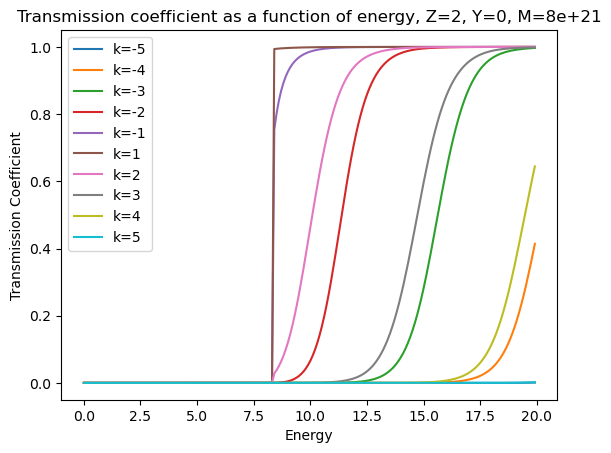

In [102]:
#Plot setup
m=8e21
z_or_y=0
x=2

if z_or_y==0:
    z=x
    y=0
elif z_or_y==1:
    z=0
    y=x
else:
    print("z_or_y out of range")
    z=3
    y=3

xi=x+2

if m==1e21:
    mi=0
elif m==2e21:
    mi=1
elif m==4e21:
    mi=2
elif m==8e21:
    mi=3
else:
    print("m out of range")
    mi=4

hlist=harray[mi]
T=Tarray[mi]

#Plotting
plt.plot(hlist*(8*np.pi*m),T[:,z_or_y,xi,0])
plt.plot(hlist*(8*np.pi*m),T[:,z_or_y,xi,1])
plt.plot(hlist*(8*np.pi*m),T[:,z_or_y,xi,2])
plt.plot(hlist*(8*np.pi*m),T[:,z_or_y,xi,3])
plt.plot(hlist*(8*np.pi*m),T[:,z_or_y,xi,4])
plt.plot(hlist*(8*np.pi*m),T[:,z_or_y,xi,5])
plt.plot(hlist*(8*np.pi*m),T[:,z_or_y,xi,6])
plt.plot(hlist*(8*np.pi*m),T[:,z_or_y,xi,7])
plt.plot(hlist*(8*np.pi*m),T[:,z_or_y,xi,8])
plt.plot(hlist*(8*np.pi*m),T[:,z_or_y,xi,9])
#plt.axvline(x=mu)
plt.xlabel("Energy")
plt.ylabel("Transmission Coefficient")
plt.title("Transmission coefficient as a function of energy, Z="+str(z)+", Y="+str(y)+", M="+str(m))
plt.legend(["k=-5","k=-4","k=-3","k=-2","k=-1","k=1","k=2","k=3","k=4","k=5"])
#plt.xlim(8,10)

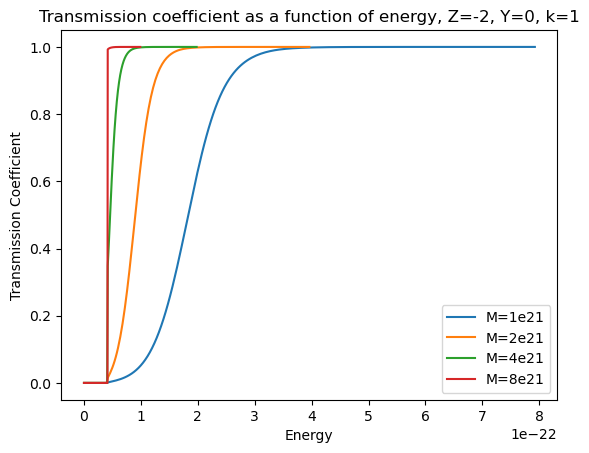

In [19]:
#Plot setup
k=1
z_or_y=0
x=-2

if z_or_y==0:
    z=x
    y=0
elif z_or_y==1:
    z=0
    y=x
else:
    print("z_or_y out of range")
    z=3
    y=3

zi=z+2
yi=y+2

if k<0 and k>=-5:
    ki=k+5
elif k>0 and k<=5:
    ki=k+4
else:
    print("k out of range")
    ki=10

#Plotting
plt.plot(hlist1,T1[:,zi,yi,ki])
plt.plot(hlist2,T2[:,zi,yi,ki])
plt.plot(hlist4,T4[:,zi,yi,ki])
plt.plot(hlist8,T8[:,zi,yi,ki])
#plt.axvline(x=mu)
plt.xlabel("Energy")
plt.ylabel("Transmission Coefficient")
plt.title("Transmission coefficient as a function of energy, Z="+str(z)+", Y="+str(y)+", k="+str(k))
plt.legend(["M=1e21","M=2e21","M=4e21","M=8e21"])

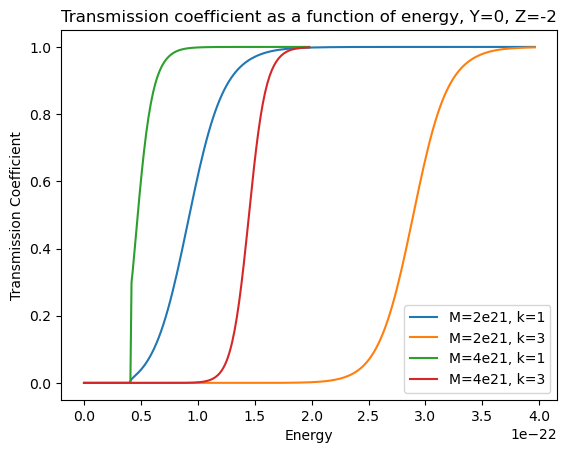

In [20]:
plt.plot(hlist2,T2[:,0,0,5])
plt.plot(hlist2,T2[:,0,0,7])
plt.plot(hlist4,T4[:,0,0,5])
plt.plot(hlist4,T4[:,0,0,7])
#plt.axvline(x=mu)
plt.xlabel("Energy")
plt.ylabel("Transmission Coefficient")
plt.title("Transmission coefficient as a function of energy, Y=0, Z=-2")
plt.legend(["M=2e21, k=1","M=2e21, k=3","M=4e21, k=1","M=4e21, k=3"])

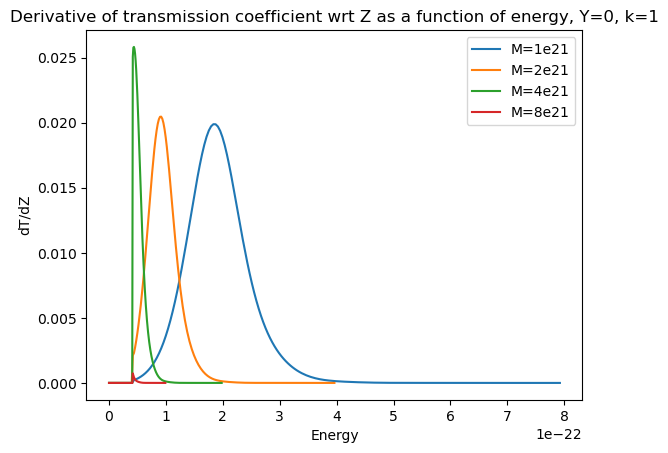

In [21]:
#Plot setup
k=1

if k<0 and k>=-5:
    ki=k+5
elif k>0 and k<=5:
    ki=k+4
else:
    print("k out of range")
    ki=10

#Plotting
plt.plot(hlist1,dTdZ1[:,ki])
plt.plot(hlist2,dTdZ2[:,ki])
plt.plot(hlist4,dTdZ4[:,ki])
plt.plot(hlist8,dTdZ8[:,ki])
plt.xlabel("Energy")
plt.ylabel("dT/dZ")
plt.title("Derivative of transmission coefficient wrt Z as a function of energy, Y=0, k="+str(k))
plt.legend(["M=1e21","M=2e21","M=4e21","M=8e21"])

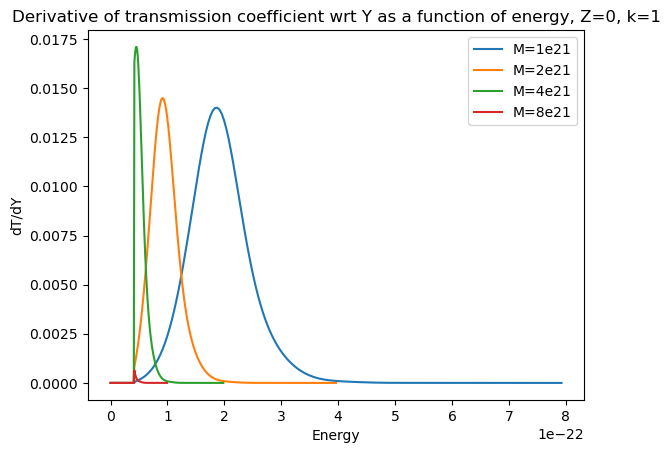

In [22]:
#Plot setup
k=1

if k<0 and k>=-5:
    ki=k+5
elif k>0 and k<=5:
    ki=k+4
else:
    print("k out of range")
    ki=10

#Plotting
plt.plot(hlist1,dTdY1[:,ki])
plt.plot(hlist2,dTdY2[:,ki])
plt.plot(hlist4,dTdY4[:,ki])
plt.plot(hlist8,dTdY8[:,ki])
plt.xlabel("Energy")
plt.ylabel("dT/dY")
plt.title("Derivative of transmission coefficient wrt Y as a function of energy, Z=0, k="+str(k))
plt.legend(["M=1e21","M=2e21","M=4e21","M=8e21"])

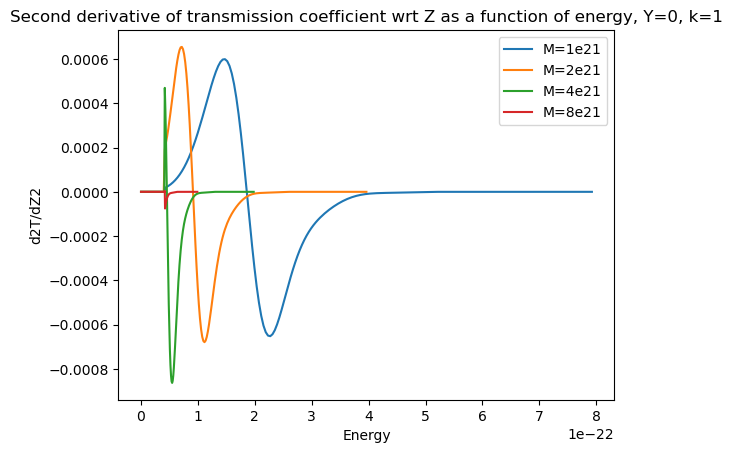

In [23]:
#Plot setup
k=1

if k<0 and k>=-5:
    ki=k+5
elif k>0 and k<=5:
    ki=k+4
else:
    print("k out of range")
    ki=10

#Plotting
plt.plot(hlist1,d2TdZ21[:,ki])
plt.plot(hlist2,d2TdZ22[:,ki])
plt.plot(hlist4,d2TdZ24[:,ki])
plt.plot(hlist8,d2TdZ28[:,ki])
plt.xlabel("Energy")
plt.ylabel("d2T/dZ2")
plt.title("Second derivative of transmission coefficient wrt Z as a function of energy, Y=0, k="+str(k))
plt.legend(["M=1e21","M=2e21","M=4e21","M=8e21"])

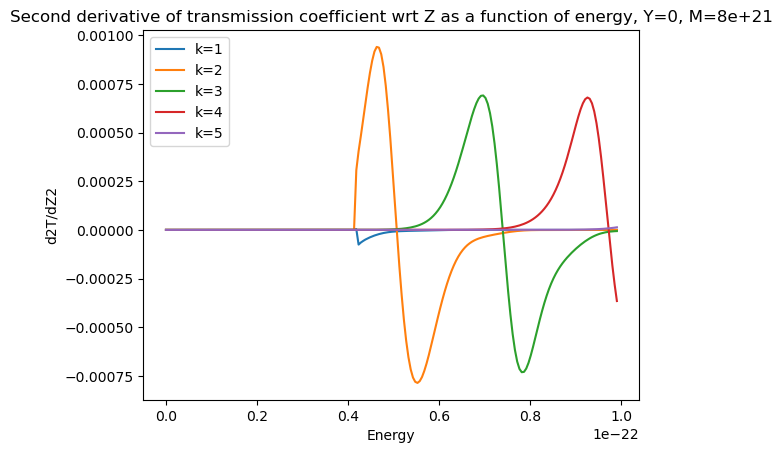

In [24]:
#Plot setup
m=8e21

if m==1e21:
    mi=0
elif m==2e21:
    mi=1
elif m==4e21:
    mi=2
elif m==8e21:
    mi=3
else:
    print("m out of range")
    mi=4

hlist=harray[mi]
d2TdZ2=d2TdZ2array[mi]

#Plotting
plt.plot(hlist,d2TdZ2[:,5])
plt.plot(hlist,d2TdZ2[:,6])
plt.plot(hlist,d2TdZ2[:,7])
plt.plot(hlist,d2TdZ2[:,8])
plt.plot(hlist,d2TdZ2[:,9])
plt.xlabel("Energy")
plt.ylabel("d2T/dZ2")
plt.title("Second derivative of transmission coefficient wrt Z as a function of energy, Y=0, M="+str(m))
plt.legend(["k=1","k=2","k=3","k=4","k=5"])

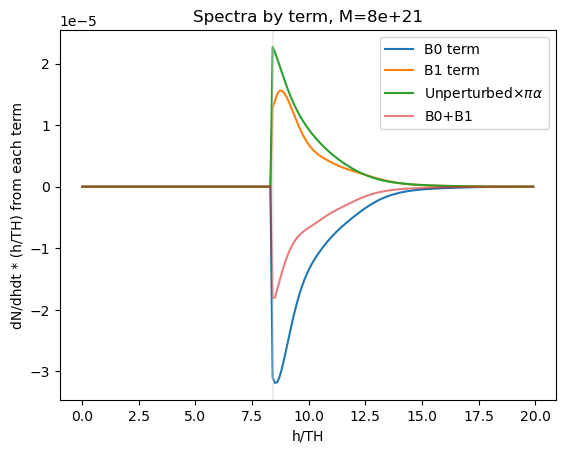

In [104]:
#Plot setup
m=8e21

if m==1e21:
    mi=0
elif m==2e21:
    mi=1
elif m==4e21:
    mi=2
elif m==8e21:
    mi=3
else:
    print("m out of range")
    mi=4

hlist=harray[mi]
b0=b0array[mi]
b1=b1array[mi]
tu=tuarray[mi]

#Plotting
plt.plot(hlist*(8*np.pi*m),b0*hlist*(8*np.pi*m))
plt.plot(hlist*(8*np.pi*m),b1*hlist*(8*np.pi*m))
#plt.plot(hlist*(8*np.pi*m),tu*hlist*(8*np.pi*m)*np.pi*alpha)
plt.plot(hlist*(8*np.pi*m),(b0+b1)*hlist*(8*np.pi*m),alpha=0.6)
plt.axvline(x=mu*(8*np.pi*m),color="lightgray",alpha=0.4)
plt.xlabel("h/TH")
plt.ylabel("dN/dhdt * (h/TH) from each term")
plt.title("Spectra by term, M="+str(m))
#plt.legend(["B0 term","B1 term",r"Unperturbed$\times \pi \alpha$","B0+B1"])
plt.legend(["B0 term","B1 term","B0+B1"])
#plt.legend(["B0 term","B1 term"])
#plt.xlim(8,10)

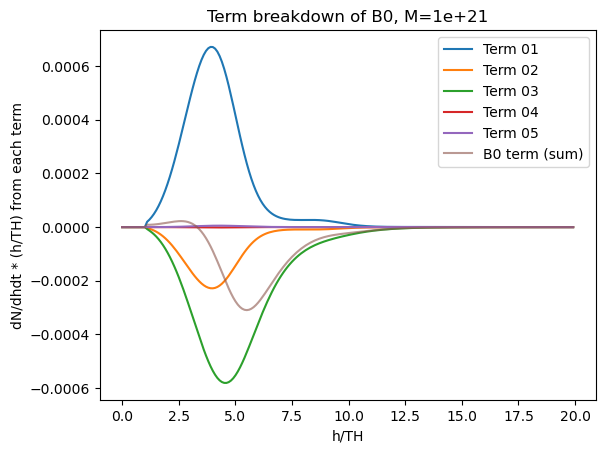

In [97]:
#Plot setup
m=1e21

if m==1e21:
    mi=0
elif m==2e21:
    mi=1
elif m==4e21:
    mi=2
elif m==8e21:
    mi=3
else:
    print("m out of range")
    mi=4

hlist=harray[mi]
b0=b0array[mi]
t01=t01array[mi]
t02=t02array[mi]
t03=t03array[mi]
t04=t04array[mi]
t05=t05array[mi]

#Plotting
plt.plot(hlist*(8*np.pi*m),t01*hlist*(8*np.pi*m))
plt.plot(hlist*(8*np.pi*m),t02*hlist*(8*np.pi*m))
plt.plot(hlist*(8*np.pi*m),t03*hlist*(8*np.pi*m))
plt.plot(hlist*(8*np.pi*m),t04*hlist*(8*np.pi*m))
plt.plot(hlist*(8*np.pi*m),t05*hlist*(8*np.pi*m))
plt.plot(hlist*(8*np.pi*m),b0*hlist*(8*np.pi*m),alpha=0.6)
plt.xlabel("h/TH")
plt.ylabel("dN/dhdt * (h/TH) from each term")
plt.title("Term breakdown of B0, M="+str(m))
plt.legend(["Term 01","Term 02","Term 03","Term 04","Term 05","B0 term (sum)"
           ])
#plt.xlim(8,10)

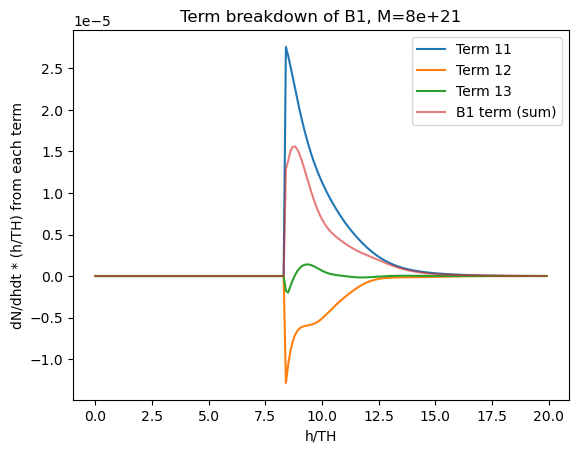

In [66]:
#Plot setup
m=8e21

if m==1e21:
    mi=0
elif m==2e21:
    mi=1
elif m==4e21:
    mi=2
elif m==8e21:
    mi=3
else:
    print("m out of range")
    mi=4

hlist=harray[mi]
b1=b1array[mi]
t11=t11array[mi]
t12=t12array[mi]
t13=t13array[mi]

#Plotting
plt.plot(hlist8*(8*np.pi*m8),t11*hlist8*(8*np.pi*m8))
plt.plot(hlist8*(8*np.pi*m8),t12*hlist8*(8*np.pi*m8))
plt.plot(hlist8*(8*np.pi*m8),t13*hlist8*(8*np.pi*m8))
plt.plot(hlist8*(8*np.pi*m8),b1*hlist8*(8*np.pi*m8),alpha=0.6)
plt.xlabel("h/TH")
plt.ylabel("dN/dhdt * (h/TH) from each term")
plt.title("Term breakdown of B1, M="+str(m))
plt.legend(["Term 11","Term 12","Term 13","B1 term (sum)"
           ])
#plt.xlim(8,10)

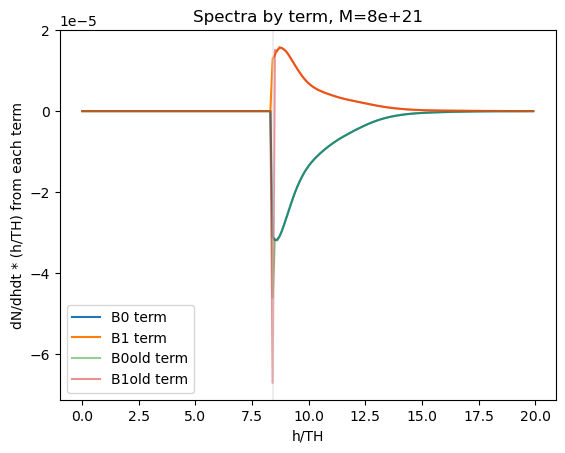

In [37]:
'''
#Plot setup
m=8e21

if m==1e21:
    mi=0
elif m==2e21:
    mi=1
elif m==4e21:
    mi=2
elif m==8e21:
    mi=3
else:
    print("m out of range")
    mi=4

hlist=harray[mi]
b0=b0array[mi]
b1=b1array[mi]
b0old=b0oldarray[mi]
b1old=b1oldarray[mi]

#Plotting
plt.plot(hlist*(8*np.pi*m),b0*hlist*(8*np.pi*m))
plt.plot(hlist*(8*np.pi*m),b1*hlist*(8*np.pi*m))
#plt.plot(hlist*(8*np.pi*m),(b0+b1)*hlist*(8*np.pi*m),alpha=0.6)
plt.plot(hlist*(8*np.pi*m),b0old*hlist*(8*np.pi*m),alpha=0.5)
plt.plot(hlist*(8*np.pi*m),b1old*hlist*(8*np.pi*m),alpha=0.5)
#plt.plot(hlist*(8*np.pi*m),(b0old+b1old)*hlist*(8*np.pi*m),alpha=0.6)
plt.axvline(x=mu*(8*np.pi*m),color="lightgray",alpha=0.4)
plt.xlabel("h/TH")
plt.ylabel("dN/dhdt * (h/TH) from each term")
plt.title("Spectra by term, M="+str(m))
#plt.legend(["B0 term","B1 term","B0+B1"])
plt.legend(["B0 term","B1 term","B0old term","B1old term"])
#plt.xlim(2.5,5)
#plt.ylim(-5e-5,5e-5)
'''

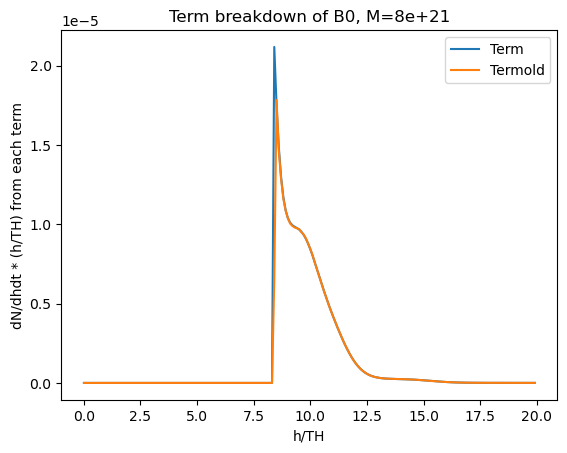

In [29]:
'''
#Plot setup
m=8e21

if m==1e21:
    mi=0
elif m==2e21:
    mi=1
elif m==4e21:
    mi=2
elif m==8e21:
    mi=3
else:
    print("m out of range")
    mi=4

hlist=harray[mi]
b0=b0array[mi]
t01=t01array[mi]
t02=t02array[mi]
t03=t03array[mi]
t04=t04array[mi]
t05=t05array[mi]
b0old=b0oldarray[mi]
t01old=t01oldarray[mi]
t02old=t02oldarray[mi]
t03old=t03oldarray[mi]
t04old=t04oldarray[mi]
t05old=t05oldarray[mi]

#Plotting
plt.plot(hlist*(8*np.pi*m),t01*hlist*(8*np.pi*m))
#plt.plot(hlist*(8*np.pi*m),t02*hlist*(8*np.pi*m))
#plt.plot(hlist*(8*np.pi*m),t03*hlist*(8*np.pi*m))
#plt.plot(hlist*(8*np.pi*m),t04*hlist*(8*np.pi*m))
#plt.plot(hlist*(8*np.pi*m),t05*hlist*(8*np.pi*m))
plt.plot(hlist*(8*np.pi*m),t01old*hlist*(8*np.pi*m))
#plt.plot(hlist*(8*np.pi*m),t02old*hlist*(8*np.pi*m))
#plt.plot(hlist*(8*np.pi*m),t03old*hlist*(8*np.pi*m))
#plt.plot(hlist*(8*np.pi*m),t04old*hlist*(8*np.pi*m))
#plt.plot(hlist*(8*np.pi*m),t05old*hlist*(8*np.pi*m))
plt.xlabel("h/TH")
plt.ylabel("dN/dhdt * (h/TH) from each term")
plt.title("Term breakdown of B0, M="+str(m))
plt.legend(["Term"
            ,"Termold"
           ])
'''

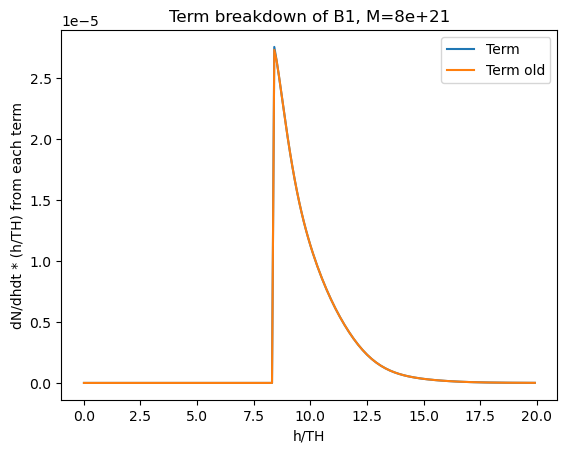

In [30]:
'''
#Plot setup
m=8e21

if m==1e21:
    mi=0
elif m==2e21:
    mi=1
elif m==4e21:
    mi=2
elif m==8e21:
    mi=3
else:
    print("m out of range")
    mi=4

hlist=harray[mi]
b1=b1array[mi]
t11=t11array[mi]
t12=t12array[mi]
t13=t13array[mi]
b1old=b1oldarray[mi]
t11old=t11oldarray[mi]
t12old=t12oldarray[mi]
t13old=t13oldarray[mi]

#Plotting
plt.plot(hlist8*(8*np.pi*m8),t11*hlist8*(8*np.pi*m8))
#plt.plot(hlist8*(8*np.pi*m8),t12*hlist8*(8*np.pi*m8))
#plt.plot(hlist8*(8*np.pi*m8),t13*hlist8*(8*np.pi*m8))
plt.plot(hlist8*(8*np.pi*m8),t11old*hlist8*(8*np.pi*m8))
#plt.plot(hlist8*(8*np.pi*m8),t12old*hlist8*(8*np.pi*m8))
#plt.plot(hlist8*(8*np.pi*m8),t13old*hlist8*(8*np.pi*m8))
plt.xlabel("h/TH")
plt.ylabel("dN/dhdt * (h/TH) from each term")
plt.title("Term breakdown of B1, M="+str(m))
plt.legend(["Term"
            ,"Term old"
           ])
#plt.ylim(-0.25e-5,0.25e-5)
#plt.xlim(8,12)
'''

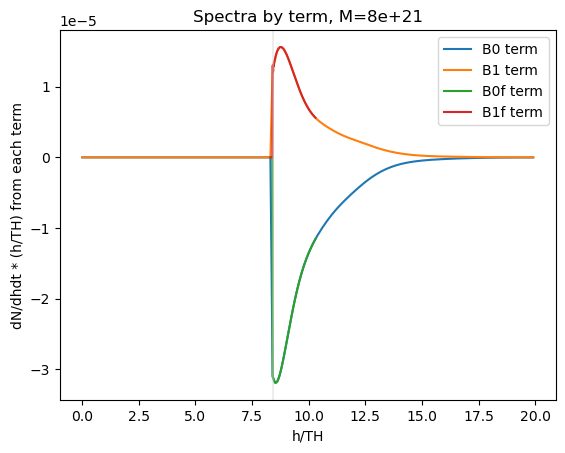

In [31]:
#Plot setup
m=8e21

if m==1e21:
    mi=0
elif m==2e21:
    mi=1
elif m==4e21:
    mi=2
elif m==8e21:
    mi=3
else:
    print("m out of range")
    mi=4

hlist=harray[mi]
hlistf=hfarray[mi]
b0=b0array[mi]
b1=b1array[mi]
b0f=b08f
b1f=b18f

#Plotting
plt.plot(hlist*(8*np.pi*m),b0*hlist*(8*np.pi*m))
plt.plot(hlist*(8*np.pi*m),b1*hlist*(8*np.pi*m))
plt.plot(hlistf*(8*np.pi*m),b0f*hlistf*(8*np.pi*m))
plt.plot(hlistf*(8*np.pi*m),b1f*hlistf*(8*np.pi*m))
plt.axvline(x=mu*(8*np.pi*m),color="lightgray",alpha=0.4)
plt.xlabel("h/TH")
plt.ylabel("dN/dhdt * (h/TH) from each term")
plt.title("Spectra by term, M="+str(m))
plt.legend(["B0 term","B1 term","B0f term","B1f term"])
#plt.xlim(8,12)
#plt.ylim(-0.05,0.02)